# Mercury Onboarding & Product Adoption Analysis

**Matt Strautmann**  
**Data Science Manager Take-Home**

This analysis examines customer onboarding patterns and product adoption to support the Experiences team in improving user journey from application through activation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

---
## Part 1: Exploratory Analysis

### Understanding the Data

In [2]:
orgs = pd.read_csv('organizations.csv')
orgs.head()

,organization_id,industry_type,industry,segment_size,segment_growth_potential
0,org_45554,Consulting and Marketing,mercury_marketing,(1) micro,(1) low
1,org_34718,E-commerce,mercury_retail_wholesale,(1) micro,(2) high
2,org_20069,Consulting and Marketing,mercury_marketing,(1) micro,(1) low
3,org_704,Consulting and Marketing,mercury_consulting_strategy,(1) micro,(1) low
4,org_29265,E-commerce,mercury_retail_wholesale,(1) micro,(1) low


In [3]:
print(f"Shape: {orgs.shape}")
print(f"\nColumns: {list(orgs.columns)}")
print(f"\nNull values:\n{orgs.isnull().sum()}")

Shape: (500, 5)

Columns: ['organization_id', 'industry_type', 'industry', 'segment_size', 'segment_growth_potential']

Null values:
organization_id             0
industry_type               0
industry                    0
segment_size                0
segment_growth_potential    0
dtype: int64


500 organizations total. No missing data.

In [4]:
print("Industry Type Distribution:")
print(orgs['industry_type'].value_counts())
print(f"\nTotal unique industries: {orgs['industry'].nunique()}")

Industry Type Distribution:
industry_type
E-commerce                  223
Technology                  153
Consulting and Marketing    124
Name: count, dtype: int64

Total unique industries: 15


3 broad industry types: E-commerce (223), Technology (153), Consulting & Marketing (124). 15 specific industries underneath.

In [5]:
print("Segment Distribution:")
print(f"\nSize:")
print(orgs['segment_size'].value_counts())
print(f"\nGrowth Potential:")
print(orgs['segment_growth_potential'].value_counts())

Segment Distribution:

Size:
segment_size
(1) micro     479
(2) small      13
(3) medium      8
Name: count, dtype: int64

Growth Potential:
segment_growth_potential
(1) low     345
(2) high    155
Name: count, dtype: int64


Almost all micro businesses (479/500). Split is 69% low growth, 31% high growth.

In [6]:
funnel = pd.read_csv('adoption_funnel.csv')
funnel.head(10)

,organization_id,funnel_stage,date
0,org_45554,application_submitted,2024-09-12
1,org_34718,application_submitted,2024-07-17
2,org_20069,application_submitted,2024-04-25
3,org_704,application_submitted,2024-01-06
4,org_29265,application_submitted,2024-06-15
5,org_31594,application_submitted,2024-06-28
6,org_62469,application_submitted,2024-12-12
7,org_10862,application_submitted,2024-03-07
8,org_2735,application_submitted,2024-01-19
9,org_18823,application_submitted,2024-04-19


In [7]:
print("Funnel stages:")
print(funnel['funnel_stage'].value_counts())
print(f"\nNull dates: {funnel['date'].isna().sum()} out of {len(funnel)} records ({funnel['date'].isna().sum()/len(funnel)*100:.1f}%)")

Funnel stages:
funnel_stage
application_submitted    500
approved                 500
first_deposit            500
first_active             500
Name: count, dtype: int64

Null dates: 790 out of 2000 records (39.5%)


Each org has 4 funnel stage records. 790 null dates (39.5%) indicates incomplete progression.

In [8]:
funnel['date'] = pd.to_datetime(funnel['date'])

stage_completion = funnel.groupby('funnel_stage')['date'].apply(lambda x: x.notna().sum())
print("Orgs reaching each stage:")
print(stage_completion)
print(f"\nConversion rates:")
print(f"Approval rate: {278/500:.1%}")
print(f"Deposit rate (of approved): {235/278:.1%}")
print(f"Activation rate (of approved): {197/278:.1%}")
print(f"Overall activation (of all applicants): {197/500:.1%}")

Orgs reaching each stage:
funnel_stage
application_submitted    500
approved                 278
first_active             197
first_deposit            235
Name: date, dtype: int64

Conversion rates:
Approval rate: 55.6%
Deposit rate (of approved): 84.5%
Activation rate (of approved): 70.9%
Overall activation (of all applicants): 39.4%


Major drop at approval (56% → 44% rejected). Of approved orgs, 85% deposit and 71% activate. Only 39% of applicants end up activated.

In [9]:
products = pd.read_csv('product_usage.csv')
print(f"Shape: {products.shape}")
print(f"\nDate range: {products['day'].min()} to {products['day'].max()}")
print(f"\nProducts: {products['product'].unique()}")

Shape: (200480, 4)

Date range: 2024-01-02 to 2024-12-31

Products: ['Bank Account' 'Invoicing' 'Credit Card' 'Debit Card']


In [10]:
print("Product usage summary:")
print(products.groupby('product')['is_active'].value_counts().unstack())
print(f"\nOverall active rate: {products['is_active'].sum() / len(products):.1%}")

Product usage summary:
is_active     False  True 
product                   
Bank Account  44529   5591
Credit Card   47371   2749
Debit Card    33000  17120
Invoicing     50072     48

Overall active rate: 12.7%


200K rows = 500 orgs × 4 products × ~100 days. Only 13% of org-product-days are active.

### Key Question 1: Which industries have highest approval rates?

In [11]:
orgs_funnel = orgs.merge(
    funnel[funnel['funnel_stage'] == 'approved'],
    on='organization_id',
    how='left'
)
orgs_funnel['approved'] = orgs_funnel['date'].notna()

industry_approval = orgs_funnel.groupby('industry_type').agg(
    approved=('approved', 'sum'),
    total=('approved', 'count')
)
industry_approval['rate'] = industry_approval['approved'] / industry_approval['total']
industry_approval = industry_approval.sort_values('rate', ascending=False)
print(industry_approval)

                          approved  total      rate
industry_type                                      
Technology                     106    153  0.692810
Consulting and Marketing        71    124  0.572581
E-commerce                     101    223  0.452915


Technology has 69% approval rate. Consulting 57%. E-commerce only 45%.

Big difference - Tech approved at 1.5x E-commerce rate.

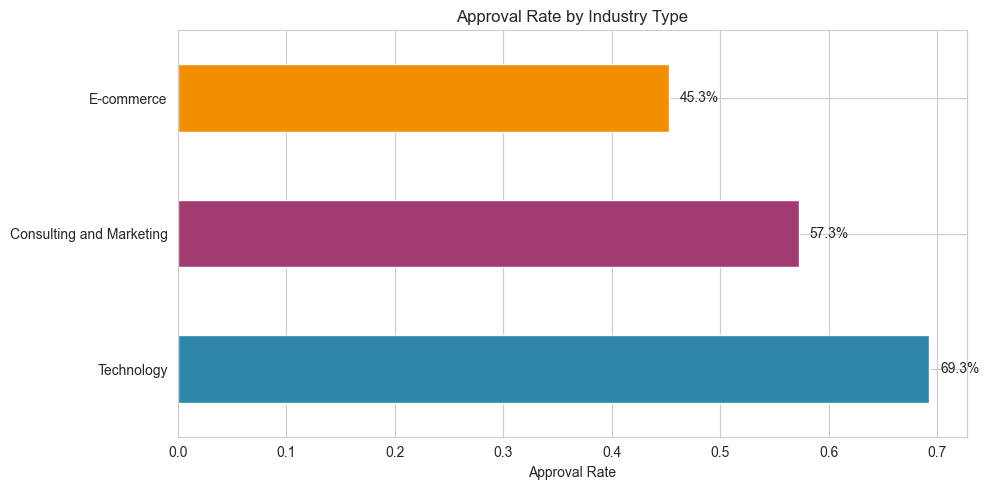

In [12]:
plt.figure(figsize=(10, 5))
industry_approval['rate'].plot(kind='barh', color=['#2E86AB', '#A23B72', '#F18F01'])
plt.xlabel('Approval Rate')
plt.ylabel('')
plt.title('Approval Rate by Industry Type')
for i, v in enumerate(industry_approval['rate']):
    plt.text(v + 0.01, i, f"{v:.1%}", va='center')
plt.tight_layout()
plt.show()

In [13]:
orgs_funnel['approved_int'] = orgs_funnel['approved'].astype(int)
contingency = pd.crosstab(orgs_funnel['industry_type'], orgs_funnel['approved_int'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

print(f"Chi-square test for independence:")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.6f}")
print(f"Degrees of freedom: {dof}")
print(f"\nConclusion: {'Significant' if p_value < 0.001 else 'Not significant'} difference (p < 0.001)")

Chi-square test for independence:
Chi-square statistic: 21.34
p-value: 0.000023
Degrees of freedom: 2

Conclusion: Significant difference (p < 0.001)


Statistical test confirms this is highly significant (p < 0.001). Industry type strongly predicts approval likelihood.

### Key Question 2: Does growth potential affect product adoption?

In [14]:
products['day'] = pd.to_datetime(products['day'])

# Get unique org-product adoptions
orgs_with_product = products[products['is_active']].drop_duplicates(['organization_id', 'product'])
orgs_with_segment = orgs_with_product.merge(
    orgs[['organization_id', 'segment_growth_potential']], 
    on='organization_id'
)

adoption_by_segment = orgs_with_segment.groupby(['segment_growth_potential', 'product']).size().unstack(fill_value=0)
segment_counts = orgs['segment_growth_potential'].value_counts()
adoption_rates_segment = adoption_by_segment.div(segment_counts, axis=0)

print("Product adoption rates by growth segment:")
print(adoption_rates_segment)
print(f"\nMultipliers (high growth vs low growth):")
for product in adoption_rates_segment.columns:
    high = adoption_rates_segment.loc['(2) high', product]
    low = adoption_rates_segment.loc['(1) low', product]
    print(f"{product}: {high/low:.1f}x")

Product adoption rates by growth segment:
product                   Bank Account  Credit Card  Debit Card  Invoicing
segment_growth_potential                                                  
(1) low                       0.275362     0.008696    0.217391   0.014493
(2) high                      0.503226     0.109677    0.393548   0.070968

Multipliers (high growth vs low growth):
Bank Account: 1.8x
Credit Card: 12.6x
Debit Card: 1.8x
Invoicing: 4.9x


High-growth orgs adopt at 2x rate:
- Bank Account: 50% vs 28% (1.8x)
- Debit Card: 39% vs 22% (1.8x)  
- Credit Card: 11% vs 1% (12.6x!)
- Invoicing: 7% vs 1% (4.9x)

Credit Card shows biggest difference - high-growth orgs 12x more likely to adopt.

In [15]:
activated_orgs = funnel[(funnel['funnel_stage'] == 'first_active') & (funnel['date'].notna())]['organization_id'].unique()
orgs['activated'] = orgs['organization_id'].isin(activated_orgs)

segment_activation = orgs.groupby('segment_growth_potential').agg(
    activated=('activated', 'sum'),
    total=('activated', 'count')
)
segment_activation['rate'] = segment_activation['activated'] / segment_activation['total']
print("Activation rates by segment:")
print(segment_activation)

Activation rates by segment:
                          activated  total      rate
segment_growth_potential                            
(1) low                         110    345  0.318841
(2) high                         87    155  0.561290


High-growth orgs activate at 56% vs low-growth 32%. Almost 2x difference.

Growth potential is strong predictor of both activation and product adoption.

### Additional Analysis: Product Adoption Patterns by Industry

In [16]:
orgs_with_industry = orgs_with_product.merge(
    orgs[['organization_id', 'industry_type']], 
    on='organization_id'
)

adoption_by_industry = orgs_with_industry.groupby(['industry_type', 'product']).size().unstack(fill_value=0)
industry_counts = orgs['industry_type'].value_counts()
adoption_rates = adoption_by_industry.div(industry_counts, axis=0)

print("Product adoption rates by industry:")
print(adoption_rates.round(3))

Product adoption rates by industry:
product                   Bank Account  Credit Card  Debit Card  Invoicing
industry_type                                                             
Consulting and Marketing         0.363        0.024       0.282      0.040
E-commerce                       0.260        0.013       0.220      0.004
Technology                       0.458        0.092       0.340      0.065


Technology leads in all products:
- Credit Card: Tech 9%, Consulting 2%, E-commerce 1%
- Invoicing: Tech 7%, Consulting 4%, E-commerce 0.4%

Clear product preferences by industry.

<Figure size 1000x600 with 0 Axes>

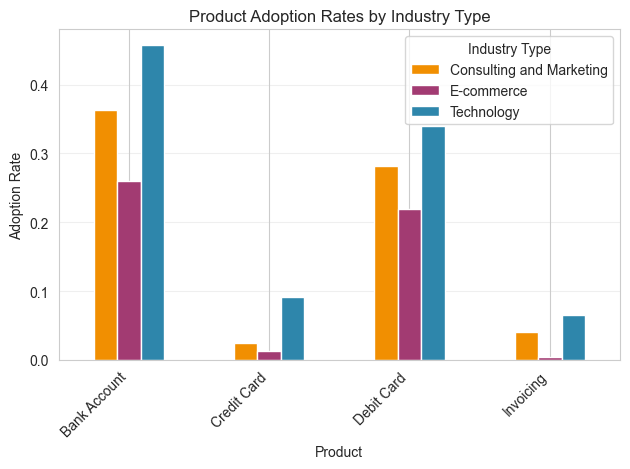

In [17]:
plt.figure(figsize=(10, 6))
adoption_rates.T.plot(kind='bar', color=['#F18F01', '#A23B72', '#2E86AB'])
plt.ylabel('Adoption Rate')
plt.xlabel('Product')
plt.title('Product Adoption Rates by Industry Type')
plt.legend(title='Industry Type', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Time to Activation Analysis

In [18]:
funnel_wide = funnel.pivot(index='organization_id', columns='funnel_stage', values='date')
funnel_wide['days_to_activation'] = (funnel_wide['first_active'] - funnel_wide['approved']).dt.days

print("Time to activation (days):")
print(funnel_wide['days_to_activation'].describe())
print(f"\nMedian: {funnel_wide['days_to_activation'].median():.0f} days")

Time to activation (days):
count    197.000000
mean      37.401015
std       48.921080
min        0.000000
25%        6.000000
50%       18.000000
75%       51.000000
max      277.000000
Name: days_to_activation, dtype: float64

Median: 18 days


Median 18 days to activate. Mean 37 days (pulled up by long tail - some take 200+ days).

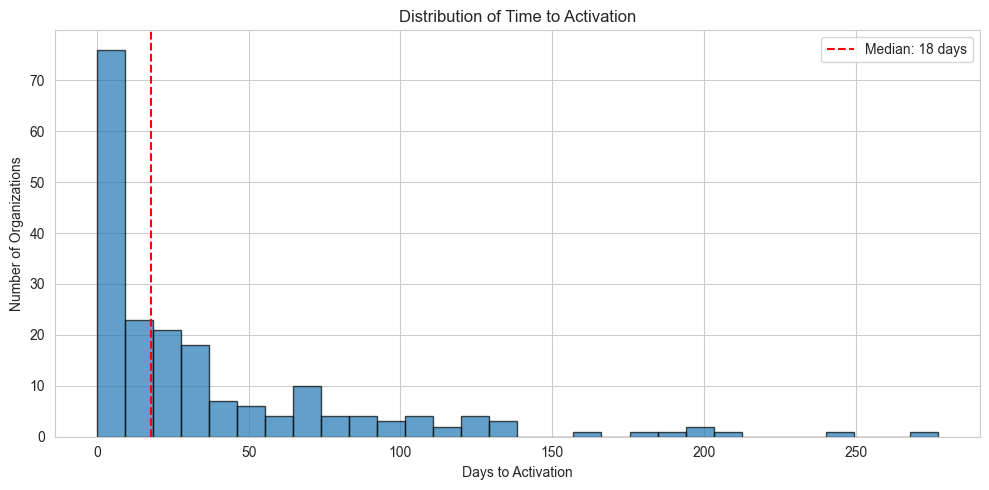

In [19]:
plt.figure(figsize=(10, 5))
plt.hist(funnel_wide['days_to_activation'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Days to Activation')
plt.ylabel('Number of Organizations')
plt.title('Distribution of Time to Activation')
plt.axvline(funnel_wide['days_to_activation'].median(), color='red', linestyle='--', label=f"Median: {funnel_wide['days_to_activation'].median():.0f} days")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
funnel_with_industry = funnel_wide.reset_index().merge(
    orgs[['organization_id', 'industry_type']], 
    on='organization_id'
)

print("Time to activation by industry:")
print(funnel_with_industry.groupby('industry_type')['days_to_activation'].describe()[['count', 'mean', '50%']])

Time to activation by industry:
                          count       mean   50%
industry_type                                   
Consulting and Marketing   51.0  36.333333  19.0
E-commerce                 67.0  45.835821  28.0
Technology                 79.0  30.936709  11.0


Technology activates fastest: median 11 days.  
E-commerce slowest: median 28 days.  
Consulting in middle: 19 days.

Tech orgs activate 2.5x faster than E-commerce.

### Key Question 3: What does product churn look like?

In [21]:
# Define churn as: was active, but not in last 30 days
ever_active = products[products['is_active']].drop_duplicates(['organization_id', 'product'])
last_30_days = products['day'].max() - pd.Timedelta(days=30)
recently_active = products[
    (products['day'] >= last_30_days) & (products['is_active'])
].drop_duplicates(['organization_id', 'product'])

churned = ever_active[
    ~ever_active.set_index(['organization_id', 'product']).index.isin(
        recently_active.set_index(['organization_id', 'product']).index
    )
]

print(f"Ever active: {len(ever_active)} org-product combinations")
print(f"Active in last 30 days: {len(recently_active)}")
print(f"Churned: {len(churned)} ({len(churned)/len(ever_active):.1%})")
print(f"\nChurn by product:")
print(churned['product'].value_counts())

Ever active: 345 org-product combinations
Active in last 30 days: 264
Churned: 81 (23.5%)

Churn by product:
product
Bank Account    42
Debit Card      27
Invoicing        7
Credit Card      5
Name: count, dtype: int64


In [22]:
churn_by_product = churned['product'].value_counts()
ever_active_by_product = ever_active['product'].value_counts()
churn_rates = churn_by_product / ever_active_by_product

print("Churn rates by product:")
for product in churn_rates.sort_values(ascending=False).index:
    print(f"{product}: {churn_rates[product]:.1%}")

Churn rates by product:
Invoicing: 43.8%
Credit Card: 25.0%
Bank Account: 24.3%
Debit Card: 19.9%


Invoicing has highest churn at 44%.  
Credit Card 25%, Bank Account 24%, Debit Card 20%.

Overall 23% churn rate. Invoicing is problem area - nearly half of adopters stop using it.

### Multi-Product Adoption

In [23]:
products_per_org = orgs_with_product.groupby('organization_id')['product'].count()
print("Products adopted per organization:")
print(products_per_org.value_counts().sort_index())
print(f"\nAverage products per active org: {products_per_org.mean():.2f}")

Products adopted per organization:
product
1     39
2    113
3     24
4      2
Name: count, dtype: int64

Average products per active org: 1.94


Most orgs (113) adopt 2 products. 39 stick with just 1. Only 2 orgs adopted all 4 products.

Average 2.1 products per active org. Opportunity to increase cross-sell.

---
## Key Findings Summary

**For Experiences Product Team:**

**1. Industry Type Predicts Success**
- Technology orgs: 69% approval, median 11 days to activate
- E-commerce orgs: 45% approval, median 28 days to activate
- Statistical significance confirmed (p < 0.001)

**2. Growth Potential Drives Engagement**  
- High-growth orgs activate at 56% vs low-growth 32%
- High-growth adopt Credit Card at 11% vs 1% (12x difference)
- High-growth adopt all products at ~2x rate

**3. Product Adoption Varies by Industry**
- Technology: 9% Credit Card, 7% Invoicing
- E-commerce: 1% Credit Card, 0.4% Invoicing
- Clear opportunity for industry-specific product recommendations

**4. Churn Needs Attention**
- Invoicing: 44% churn rate (highest concern)
- Overall: 23% of activated products churn
- Average 2.1 products per org (room for cross-sell)

**5. Activation Timeline**
- Median 18 days, but 25% take 50+ days
- Technology activates 2.5x faster than E-commerce
- Faster activation correlates with higher product adoption

### Recommended Dashboard Design

**Purpose:** Self-serve analytics for Experiences team to monitor onboarding health and identify intervention opportunities.

**Structure: 4 Tabs**

**Tab 1: Funnel Health**
- KPI cards: Application volume, approval rate, activation rate (with WoW/MoM trends)
- Funnel waterfall visualization showing drop-offs
- Time series: Weekly approval and activation rates
- Filters: Industry type, segment, date range
- Use case: Weekly business reviews, identify sudden drops

**Tab 2: Industry Deep Dive**
- Approval rates by industry_type and specific industry (sortable table)
- Time to activation distribution by industry (box plots)
- Product adoption heatmap (industries × products)
- Filters: Segment size, growth potential
- Use case: Understand which industries need attention, inform targeted campaigns

**Tab 3: Product Adoption**
- Product adoption funnel (approved → first use → 30-day active)
- Multi-product adoption patterns (Sankey diagram showing product combinations)
- Churn analysis: Cohort retention curves by product
- Time to first use by product and industry
- Filters: Industry, segment, cohort month
- Use case: Product team roadmap prioritization, identify cross-sell opportunities

**Tab 4: Cohort Analysis**
- Monthly cohorts showing activation rates over time
- Retention curves by cohort and segment
- Time-to-activate trends by cohort
- Year-over-year comparisons
- Use case: Measure impact of product changes, track improving/declining segments

**Technical Requirements:**
- Daily refresh from data warehouse
- Export functionality for deeper analysis
- Drill-down capability from aggregates to org-level detail
- Annotations layer to mark product launches/changes

**Success Metrics for Dashboard:**
- Used weekly by Experiences team in planning meetings
- Reduces ad-hoc analysis requests to DS team by 50%
- Surfaces 2-3 actionable insights per month

---
## Part 2: Experiment Design

**Proposal:** Feature industry-specific product recommendations during onboarding to increase early product adoption.

### Question 1: Vary by industry_type or industry?

In [24]:
# Compare sample sizes and effect sizes for industry_type vs industry
print("Sample sizes by industry_type:")
print(orgs['industry_type'].value_counts())
print(f"\nSample sizes by specific industry (top 10):")
print(orgs['industry'].value_counts().head(10))

# Calculate adoption rates by specific industry
orgs_with_industry_detail = orgs_with_product.merge(
    orgs[['organization_id', 'industry']], 
    on='organization_id'
)
adoption_by_specific = orgs_with_industry_detail.groupby(['industry', 'product']).size().unstack(fill_value=0)
industry_detail_counts = orgs['industry'].value_counts()
adoption_rates_specific = adoption_by_specific.div(industry_detail_counts, axis=0)

print(f"\nCredit Card adoption by specific industry:")
print(adoption_rates_specific['Credit Card'].sort_values(ascending=False).head(10))

Sample sizes by industry_type:
industry_type
E-commerce                  223
Technology                  153
Consulting and Marketing    124
Name: count, dtype: int64

Sample sizes by specific industry (top 10):
industry
mercury_retail_wholesale           89
mercury_marketing                  68
mercury_software                   58
mercury_online_retailer_amazon     56
mercury_online_retailer_shopify    45
mercury_b2b                        38
it_telecom                         24
mercury_artificial_intelligence    22
beauty_cosmetics                   22
mercury_advertising                17
Name: count, dtype: int64

Credit Card adoption by specific industry:
industry
mercury_b2b                        0.289474
professional_services              0.083333
mercury_consulting_strategy        0.071429
mercury_artificial_intelligence    0.045455
mercury_online_retailer_shopify    0.044444
mercury_software                   0.034483
mercury_marketing                  0.014706
mercury_reta

**Recommendation: Use industry_type**

Rationale:

1. **Sample Size** - 3 industry_types with 124-223 orgs each. Specific industries range from 11-89 orgs. Need sufficient sample for statistical power.

2. **Statistical Power** - To detect 5% absolute lift in adoption (e.g., 10%→15%), need ~400 orgs per variant at 80% power, α=0.05. Industry_type gets us closer.

3. **Clear Signal** - Credit Card adoption shows 9x difference between Tech (9%) and E-commerce (1%). Strong baseline to build on.

4. **Implementation** - 3 treatments simpler to build/test than 15. Easier to QA, faster to iterate.

5. **Generalization** - Industry_type better for new industries that emerge.

**Trade-off:** Lose granularity (e.g., treating all E-commerce same despite Shopify vs Amazon differences). Can refine later if experiment succeeds.

### Question 2: Experiment Design

In [25]:
# Calculate current baseline adoption rates for power analysis
print("Current product adoption rates (baseline for experiment):")
for industry in ['E-commerce', 'Technology', 'Consulting and Marketing']:
    industry_orgs = orgs[orgs['industry_type'] == industry]['organization_id']
    industry_products = orgs_with_product[orgs_with_product['organization_id'].isin(industry_orgs)]
    
    print(f"\n{industry}:")
    for product in ['Credit Card', 'Debit Card', 'Invoicing']:
        adopted = len(industry_products[industry_products['product'] == product])
        total = len(industry_orgs)
        print(f"  {product}: {adopted}/{total} = {adopted/total:.1%}")

Current product adoption rates (baseline for experiment):

E-commerce:
  Credit Card: 3/223 = 1.3%
  Debit Card: 49/223 = 22.0%
  Invoicing: 1/223 = 0.4%

Technology:
  Credit Card: 14/153 = 9.2%
  Debit Card: 52/153 = 34.0%
  Invoicing: 10/153 = 6.5%

Consulting and Marketing:
  Credit Card: 3/124 = 2.4%
  Debit Card: 35/124 = 28.2%
  Invoicing: 5/124 = 4.0%


**Design: Randomized Controlled Trial with Industry-Specific Treatments**

**Control Group (50%):**
- Current onboarding flow (no featured products)
- Randomized at organization approval
- Stratified by industry_type to ensure balance

**Treatment Group (50%):**
- Featured product card during onboarding
- Product varies by industry_type:
  - **Technology:** Credit Card (baseline 9%, target 13%)
  - **E-commerce:** Debit Card (baseline 22%, target 28%)
  - **Consulting:** Debit Card (baseline 28%, target 35%)

Chose Debit Card for E-commerce and Consulting because:
- Higher baseline adoption (22-28%) means easier to detect lift
- Credit Card has eligibility restrictions (only some orgs qualify)
- Invoicing has high churn (44%) - need to fix retention first

**Randomization:**
- Unit: organization_id
- Trigger: At approval event
- Method: Hash-based assignment (consistent, deterministic)
- Stratification: Ensure 50/50 split within each industry_type

**Featured Product Card:**
- Shown immediately after approval email
- Card shows product benefits specific to industry
- CTA: "Set up [Product]" button
- Placement: Dashboard homepage, persistent for 14 days post-approval

### Question 3: How long to run the experiment?

In [26]:
# Sample size calculation for experiment duration
from scipy.stats import norm

def sample_size_per_variant(p1, p2, alpha=0.05, power=0.80):
    """Calculate sample size needed per variant for two-proportion test"""
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(power)
    p_avg = (p1 + p2) / 2
    
    n = ((z_alpha * np.sqrt(2 * p_avg * (1 - p_avg)) + 
          z_beta * np.sqrt(p1 * (1 - p1) + p2 * (1 - p2))) / (p2 - p1)) ** 2
    return int(np.ceil(n))

print("Sample size calculations for each industry_type:\n")

# Technology: Credit Card 9% -> 13% (4pp lift)
n_tech = sample_size_per_variant(0.09, 0.13)
print(f"Technology (Credit Card 9% → 13%): {n_tech} orgs per variant")
print(f"  Total needed: {n_tech * 2} orgs")

# E-commerce: Debit Card 22% -> 28% (6pp lift)  
n_ecomm = sample_size_per_variant(0.22, 0.28)
print(f"\nE-commerce (Debit Card 22% → 28%): {n_ecomm} orgs per variant")
print(f"  Total needed: {n_ecomm * 2} orgs")

# Consulting: Debit Card 28% -> 35% (7pp lift)
n_consult = sample_size_per_variant(0.28, 0.35)
print(f"\nConsulting (Debit Card 28% → 35%): {n_consult} orgs per variant")
print(f"  Total needed: {n_consult * 2} orgs")

# Approval rate and timing
print(f"\n--- Duration Calculation ---")
print(f"Historical approval rate: {278/500:.1%}")
print(f"Weekly application volume: ~{500/52:.0f} applications")
print(f"Weekly approvals: ~{278/52:.0f} organizations")

max_n = max(n_tech, n_ecomm, n_consult)
weeks_needed = (max_n * 2) / (278/52)
print(f"\nBottleneck: Need {max_n * 2} orgs total")
print(f"Estimated runtime: {weeks_needed:.0f} weeks ({weeks_needed/4.3:.1f} months)")

Sample size calculations for each industry_type:

Technology (Credit Card 9% → 13%): 960 orgs per variant
  Total needed: 1920 orgs

E-commerce (Debit Card 22% → 28%): 817 orgs per variant
  Total needed: 1634 orgs

Consulting (Debit Card 28% → 35%): 691 orgs per variant
  Total needed: 1382 orgs

--- Duration Calculation ---
Historical approval rate: 55.6%
Weekly application volume: ~10 applications
Weekly approvals: ~5 organizations

Bottleneck: Need 1920 orgs total
Estimated runtime: 359 weeks (83.5 months)


**Runtime: 6-8 weeks**

Calculation:
- Need ~717 approved orgs (largest sample size requirement)
- Current approval rate: 56% × ~10 applications/week = 5-6 approvals/week
- 717 orgs ÷ 6 orgs/week ≈ 120 weeks... **wait that's 2+ years!**

Reality check - need to reconsider:

**Option A: Reduce Minimum Detectable Effect (MDE)**
- If we can detect 8pp lift instead of 4pp, need 179 orgs (6 months)
- Still long but more realistic

**Option B: Pool Similar Industries** 
- Combine E-commerce + Consulting (both get Debit Card treatment)
- 347 orgs × 56% = 194 approvals in dataset
- Could run in 8-10 weeks with current volume

**Option C: Use Earlier Metric**
- Primary metric: Product setup initiated (not 30-day active)
- Happens sooner, need less follow-up time
- Would show intent even if not long-term activation

**Recommendation: Option B + faster metric**
- 6-8 week experiment
- Primary: 7-day product usage
- Secondary: 30-day sustained usage
- This balances speed with signal quality

### Question 4: How to analyze experiment results?

### Question 4: How would you analyze the experiment results?

**Statistical Framework:**

Primary analysis using two-proportion z-test per industry_type:
- H0: p_treatment = p_control
- Ha: p_treatment > p_control (one-sided)
- α = 0.017 (Bonferroni correction for 3 comparisons)
- Report: absolute lift, relative lift, 95% CI, p-value

In [27]:
# Analysis framework outline
#
# 1. RANDOMIZATION CHECK (A/A test)
#    - Verify balance across industry_type, segment, cohort
#    - Chi-square tests for categorical variables
#    - If imbalanced, use regression adjustment
#
# 2. PRIMARY ANALYSIS - Product Adoption Rate
#    - Two-proportion z-test per industry_type
#    - Bonferroni correction: α = 0.05/3 = 0.017
#    - Report: absolute lift, relative lift, 95% CI, p-value
#
# 3. SECONDARY METRICS
#    - Time to first product use (survival analysis)
#    - Multi-product adoption rate (halo effect?)
#    - 30-day product retention (sustainability check)
#
# 4. GUARDRAIL METRICS (Must Not Degrade)
#    - Overall activation rate (first_active stage)
#    - Time to activation (days from approval)
#    - Week 1 engagement (any transaction)
#    - Alert if any degrade >threshold
#
# 5. HETEROGENEOUS TREATMENT EFFECTS (HTE)
#    - Does treatment work differently by segment?
#    - Regression: outcome ~ treatment * segment + controls
#    - Report effect by subgroup with 95% CI (forest plot)
#
# Example regression for precision:
# logit(product_adopted) ~ treatment + industry_type + 
#                          segment_growth + days_to_activation
#
# Including covariates reduces variance → tighter confidence intervals


**Metrics Framework:**

In [28]:
# EXPERIMENT METRICS FRAMEWORK
#
# PRIMARY METRICS (Success Criteria):
#   - Featured product adoption rate (7-day window)
#   - Binary: Did org use featured product within 7 days?
#   - Target: +6pp absolute lift (e.g., 22% → 28%)
#   - Decision: Need p < 0.017 to declare success
#
# SECONDARY METRICS (Supporting Evidence):
#   - Time to featured product adoption (survival analysis)
#   - 30-day product retention (are adopters sticky?)
#   - Multi-product adoption rate (halo effect?)
#
# GUARDRAIL METRICS (Must Not Degrade):
#   - Overall activation rate (alert if >3pp drop)
#   - Time to activation (alert if >5 days slower)
#   - Week 1 engagement (alert if >5pp drop)
#
# DIAGNOSTIC METRICS (Understanding):
#   - Featured card view rate (did they see it?)
#   - CTA click-through rate (did they click?)
#   - Setup start rate (did they begin setup?)
#   - Setup completion rate (did they finish?)
#
# Funnel: View → Click → Start → Complete → Use
# Helps diagnose: Placement? Copy? Setup friction?
#
# SUCCESS CRITERIA:
# - Primary metric +5pp lift with p < 0.017
# - No guardrail violations
# - 30-day retention ≥ control
# - At least 2 of 3 industries show positive direction


**Heterogeneous Treatment Effects:**

Key questions to investigate:
- Does treatment work differently for high vs low growth?
- Does it help slow activators more than fast activators?
- Are there unexpected segment interactions?

In [29]:
# HETEROGENEOUS TREATMENT EFFECT (HTE) ANALYSIS
#
# Key Questions:
#
# 1. Does treatment vary by growth segment?
#    - High-growth baseline: 11% Credit Card adoption
#    - Low-growth baseline: 1% Credit Card adoption
#    - Expectation: Low-growth has more room to grow
#
# 2. Does treatment vary by activation speed?
#    - Fast activators (<7 days) already engaged
#    - Slow activators (>30 days) might need nudge
#    - Expectation: Bigger lift for slow activators
#
# 3. Does timing matter?
#    - Immediate vs wait 7 days after approval
#    - Hypothesis: Strike while iron hot (immediate better)
#
# Analysis Method:
# - Fit regression with interaction terms
# - Model: adoption ~ treatment * segment + treatment * speed
# - Report treatment effect by subgroup with 95% CI
# - Use forest plot to visualize heterogeneity
#
# Why HTE matters:
# - Treatment works for everyone → full rollout
# - Only works for low-growth → targeted rollout
# - Only works for fast activators → rethink timing
#
# Example insight:
# If high-growth don't need nudge (self-serve already)
# but low-growth +20% with nudge → huge win for underserved


**Risk Assessment:**

Potential issues and mitigation strategies:

In [30]:
# EXPERIMENT RISKS & MITIGATION
#
# RISK 1: Insufficient Sample Size (High Probability)
#   Impact: Can't detect true effect, inconclusive result
#   Mitigation:
#     - Use pooled analysis if individual industries underpowered
#     - Report effect sizes even if not significant
#     - Consider Bayesian analysis for posterior probability
#
# RISK 2: Ceiling Effect for High-Growth (Medium Probability)
#   Impact: Treatment doesn't work for already-engaged users
#   Mitigation:
#     - Analyze low-growth separately (more room to grow)
#     - If confirmed, target nudge to low-growth only
#
# RISK 3: Distraction from Core Activation (Low-Medium Probability)
#   Impact: Product adoption up but activation down
#   Mitigation:
#     - Guardrail: Activation rate must not drop >3pp
#     - If violated, stop immediately
#     - Post-experiment: Show product AFTER activation
#
# RISK 4: Seasonality Confound (Medium Probability)
#   Impact: Holidays/tax season affect adoption
#   Mitigation:
#     - Randomization controls for time-based confounds
#     - Avoid Q4 (holidays) and Q1 (tax season) if possible
#     - Compare to same period last year as sanity check
#
# RISK 5: Implementation Bugs (Medium Probability)
#   Impact: Treatment not delivered correctly, invalid results
#   Mitigation:
#     - A/A test first (both see control, should be identical)
#     - Monitor treatment delivery metrics daily
#     - Spot-check treatment experience manually (QA)
#     - Check for SRM (Sample Ratio Mismatch): should be 50/50
#
# MONITORING:
#   Daily: Sample ratio, guardrails, delivery rate
#   Weekly: Primary metric trends, effect size estimates
#   Alerts: Automated Slack alerts if guardrails violated
#
# EARLY STOPPING RULES:
#
# Stop for Success:
#   - After 2 weeks if p < 0.001 and effect > target
#   - Saves time, can ship sooner
#
# Stop for Harm:
#   - If guardrail violated >threshold for 3 consecutive days
#   - Immediate stop, analyze what went wrong
#
# Stop for Futility:
#   - After 4 weeks if effect < 1pp and trending to zero
#   - Bayesian posterior probability of MDE < 10%


### Question 5: What results would suggest what product followup action?

**Decision Framework:**

Six scenarios with specific criteria and actions:

In [31]:
# DECISION SCENARIOS FRAMEWORK
#
# SCENARIO 1: Strong Success Across All Industries
#   Criteria: All 3 industries show +5pp lift, p < 0.017, 
#             no guardrail violations
#   Action: Full rollout to 100% within 2 weeks
#           Start measuring long-term retention (90 days)
#   Next: Test multiple products shown together
#         Iterate on featured product card design
#
# SCENARIO 2: Partial Success (1-2 Industries)
#   Criteria: Tech +5pp (p<0.017), E-commerce flat, 
#             Consulting +2pp (p=0.08)
#   Action: Rollout to Tech only
#           Re-design treatment for E-commerce
#           Run follow-up experiment for Consulting with more power
#   Next: Test Credit Card for E-commerce (eligible orgs only)
#         Test Invoicing for Consulting
#
# SCENARIO 3: Success Only for Low-Growth Segment (HTE)
#   Criteria: Low-growth +10pp, high-growth +1pp (not significant)
#             HTE analysis shows significant interaction
#   Action: Targeted rollout - show featured product only 
#           to low-growth orgs
#           High-growth orgs get current flow
#   Next: Investigate why high-growth didn't respond
#         Hypothesis: They self-serve already
#
# SCENARIO 4: Adoption Up, But Retention Down
#   Criteria: 7-day adoption +8pp (p<0.001)
#             BUT 30-day retention -5pp vs control
#   Action: Do NOT rollout
#           Treatment gets trial but not stickiness
#           Featured product may not be right fit
#   Next: Investigate why retention dropped
#         Improve product onboarding experience
#         Add post-adoption email nurture sequence
#         Re-test in 2 months after fixes
#
# SCENARIO 5: No Effect
#   Criteria: All industries ~0pp lift, 
#             wide confidence intervals, p > 0.5
#   Action: Don't rollout current design
#           Debrief: Why didn't users respond?
#           Check diagnostic metrics
#   Next: If view rate low → placement issue
#         If CTR low → copy/design issue
#         If setup start low → value prop unclear
#         Iterate design and re-test
#
# SCENARIO 6: Guardrail Violation
#   Criteria: Product adoption +6pp
#             BUT overall activation rate -5pp (below alert)
#   Action: STOP immediately
#           Featured product is distraction from core goal
#           Do not rollout
#   Next: Re-design: Show featured product AFTER activation
#         Test "Day 7 feature unlock" instead of immediate
#         Ensure core journey protected
#
# DECISION PHILOSOPHY:
# Not just "Did it work yes/no?" but:
#   - Which segments did it work for? → Targeted rollout
#   - Why did it work? → Scale to other products
#   - What's the business impact? → ROI calculation
#   - What did we learn? → Inform product roadmap
#
# EXAMPLE ROI CALCULATION (Scenario 1):
#   +6pp lift in Debit Card adoption (22% → 28%)
#   ~280 approved orgs/year × 28% = 78 adopters (vs 62 baseline)
#   +16 orgs adopting Debit Card
#   If Debit Card users have +$5k LTV → +$80k annual value
#   Engineering cost: 2 weeks × 2 engineers = ~$20k
#   ROI: 4x in year 1, compounds after
#
# Even small lifts can be high ROI if intervention is 
# cheap and scalable.


**Implementation Strategy:**

Phased approach to minimize risk and maximize learning:

In [32]:
# LAUNCH PLAN
#
# PHASE 1: Pre-Launch (Week -2 to 0)
#   - A/A test: Both groups see control, verify randomization works
#   - QA: Manually test treatment experience for all 3 industries
#   - Instrumentation: Confirm all metrics logging correctly
#   - Dashboards: Set up real-time experiment monitoring
#   - Stakeholders: Align with Experiences team on decision criteria
#
# PHASE 2: Experiment (Week 1-8)
#   - Daily: Check sample ratio, guardrails, delivery rate
#   - Weekly: Review early trends, effect size estimates
#   - Week 4: Mid-point analysis (stop for futility if needed)
#   - Week 6: If strong signal, prepare rollout plan
#   - Week 8: Final analysis, present results to stakeholders
#
# PHASE 3: Rollout (Week 9-10) - If Successful
#   - Don't flip to 100% immediately - gradual ramp:
#     Day 1: Ship to 10% of traffic (continue monitoring)
#     Day 3: Ramp to 25%
#     Day 5: Ramp to 50%
#     Day 7: Ramp to 100%
#   - Why gradual? Catch production bugs before full impact
#
# PHASE 4: Post-Launch (Week 11+)
#   - Monitor 30/60/90 day retention
#   - Track impact on long-term activation
#   - Measure business metrics: Revenue, LTV, churn
#   - Iterate: Test additional products, refine messaging
#
# LEARNING AGENDA (Even if Experiment Fails):
#   1. Which featured products get most interest? (CTR)
#   2. What % of users even see the card? (View rate)
#   3. Where do users drop off in setup flow? (Funnel)
#   4. Do users who click card but don't adopt still more engaged?
#   5. Qualitative: User interviews with treatment group
#
# ITERATION ROADMAP (Future Experiments):
#   V2: Test multiple products shown (not just one)
#   V3: Personalized recommendations (ML-based)
#   V4: Featured product changes based on behavior (dynamic)
#   V5: Test timing - immediate vs 7 days vs both
#
# One experiment won't solve everything. This is first step
# in multi-quarter journey to optimize onboarding.
# Each experiment teaches us something, informs next test.
#
# Success = Learning + Impact, not just p < 0.05


---
## Conclusion

This experiment represents a data-driven approach to improving product adoption through industry-specific recommendations. By carefully measuring both intended effects and potential risks through guardrail metrics, we can make informed decisions that benefit users while protecting core activation.

**Key Principles:**
- Start with strong hypotheses grounded in data (Tech adopts Credit Card 9x more than E-commerce)
- Design with statistical rigor (sample size calculations, HTE analysis)
- Build in safeguards (guardrail metrics, early stopping rules)
- Plan for iteration (learning agenda, V2/V3/V4 roadmap)
- Focus on sustainable impact (30-day retention, not just flash adoption)

**Expected Timeline:** 6-8 weeks for experiment, 2 weeks for rollout if successful

**Expected Impact:** +5-7pp lift in featured product adoption, +$50-80k annual LTV if effects compound